# Project 3

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
import numpy as np


In [32]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print(df.head())


   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [33]:
# frequency table for prestige and whether or not someone was admitted
df.groupby(['prestige'])['admit'].value_counts()

prestige  admit
1.0       1        33
          0        28
2.0       0        95
          1        53
3.0       0        93
          1        28
4.0       0        55
          1        12
Name: admit, dtype: int64

## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [34]:
dummy_ranks = pd.get_dummies(df.prestige, prefix='prestige')

dummy_ranks.head()

,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: n-1, in this case 3

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [35]:
cols_to_keep = ['admit', 'gre', 'gpa']
handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
handCalc.head()

,admit,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


In [36]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
crosstab_freq = pd.crosstab(handCalc['prestige_1.0'], handCalc.admit,margins=True)
crosstab_freq

admit,0,1,All
prestige_1.0,,,
0,243,93,336
1,28,33,61
All,271,126,397


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [37]:
crosstab_freq.iloc[1,2]

61

In [38]:
format(crosstab_freq.iloc[1,1] / crosstab_freq.iloc[1,2],'0.2%')

'54.10%'

#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [39]:
format((crosstab_freq.iloc[0,1]) / crosstab_freq.iloc[0,2],'0.2%')

'27.68%'

#### 3.3 Calculate the odds ratio

In [40]:
(33/28)/(93/243)

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

Answer: Applicants who came from a #1 ranked college were 3 times as likely to be admited than those who did not.

#### 3.5 Print the cross tab for prestige_4

In [41]:
crosstab_freq = pd.crosstab(handCalc['prestige_4.0'], handCalc.admit,margins=True)
crosstab_freq

admit,0,1,All
prestige_4.0,,,
0,216,114,330
1,55,12,67
All,271,126,397


#### 3.6 Calculate the OR 

In [42]:
((12/55)/(114/216))

0.4133971291866028

#### 3.7 Write this finding in a sentence

Answer: Students who came from the lowest ranked school were less than half as likely to get admitted.

## Part 4. Analysis

In [43]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data.head()

,admit,gre,gpa,prestige_2.0,prestige_3.0,prestige_4.0
0,0,380.0,3.61,0,1,0
1,1,660.0,3.67,0,1,0
2,1,800.0,4.00,0,0,0
3,1,640.0,3.19,0,0,1
4,0,520.0,2.93,0,0,1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [44]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [45]:
train_cols = ['gre', 'gpa', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0' ]

#### 4.2 Fit the model

In [46]:
results = sm.Logit(data['admit'], data[train_cols]).fit()

Optimization terminated successfully.
         Current function value: 0.589121
         Iterations 5


#### 4.3 Print the summary results

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                            4
Date:                Tue, 15 Aug 2017   Pseudo R-squ.:                 0.05722
Time:                        15:07:39   Log-Likelihood:                -233.88
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.039e-05
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
gre              0.0014      0.001      1.308      0.191      -0.001       0.003
gpa             -0.1323      0.195     -0.680      0.497      -0.514       0.249
prestige_2.0    -0.9562      0.302     -3.171      0.002      -1.547      -0.365
prestige_3.0    -1.5375      0.332     -4.627      0.000      -2.189      -0.886
prestige_4.0    -1.8699      0.401     -4.658      0.000      -2.657      -1.083
================================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [48]:
np.exp(results.params)

gre             1.001368
gpa             0.876073
prestige_2.0    0.384342
prestige_3.0    0.214918
prestige_4.0    0.154135
dtype: float64

In [49]:
conf = results.conf_int()
conf['OR']= results.params
conf.columns=['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
gre,0.999320,1.003420,1.001368
gpa,0.598303,1.282800,0.876073
prestige_2.0,0.212826,0.694082,0.384342
prestige_3.0,0.112055,0.412207,0.214918
prestige_4.0,0.070176,0.338540,0.154135


#### 4.5 Interpret the OR of Prestige_2

Answer: An applicant has has lower odds of being admitted because the odds ratio is less than 1

#### 4.6 Interpret the OR of GPA

Answer: An applicant has higher odds of being admitted because the odds ratio is close to/greater than 1

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [50]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = n // arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [51]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print(gres)
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print(gpas)
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


#### 5.1 Recreate the dummy variables

In [52]:
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'admit']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'admit']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])


#### 5.2 Make predictions on the enumerated dataset

In [53]:
combos['admission']=results.predict(combos[train_cols])
combos.tail(4)

,gre,gpa,prestige,admit,prestige_2.0,prestige_3.0,prestige_4.0,admission
396,800.0,4.0,1.0,1.0,0,0,0,0.637399
397,800.0,4.0,2.0,1.0,1,0,0,0.403204
398,800.0,4.0,3.0,1.0,0,1,0,0.274202
399,800.0,4.0,4.0,1.0,0,0,1,0.213184


#### 5.3 Interpret findings for the last 4 observations

Answer: the probability of admission is higher for students with higher ranked undergraduate schools.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [59]:
combos.pivot_table?

In [73]:
### work in Progress
def strat_plot():
    combos.pivot_table(values="admission", index=[variable,'prestige'], aggfunc='mean')
    
    colors='rbgyrbgy'
    for col in combos.prestige.unique():
    
    
gre_plot

gre    gpa       prestige
220.0  2.260000  1.0         0.500412
                 2.0         0.277966
                 3.0         0.177139
                 4.0         0.133741
       2.453333  1.0         0.494018
                 2.0         0.272862
                 3.0         0.173442
                 4.0         0.130805
       2.646667  1.0         0.487625
                 2.0         0.267816
                 3.0         0.169805
                 4.0         0.127924
       2.840000  1.0         0.481237
                 2.0         0.262830
                 3.0         0.166230
                 4.0         0.125098
       3.033333  1.0         0.474854
                 2.0         0.257904
                 3.0         0.162715
                 4.0         0.122325
       3.226667  1.0         0.468480
                 2.0         0.253039
                 3.0         0.159260
                 4.0         0.119605
       3.420000  1.0         0.462116
                 2.0    

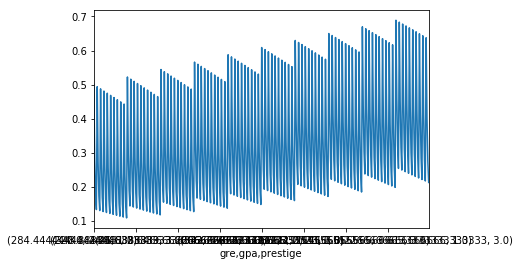

In [74]:
gre_plot.plot()

KeyError: 'gre'

In [282]:
def admit_plot(variable):
    data = group_data.loc[variable]
    plt.plot(data.index, data.values)

In [280]:
admit_plot('gre')

KeyError: 'the label [gre] is not in the [index]'